# Notebook for Data Visualization

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
# Define the data path and provinces
data_path = 'data/'
provinces = ['WHOLE KINGDOM', 'CHACHOENGSAO', 'CHONBURI', 'RAYONG']
eec = ['CHONBURI', 'CHACHOENGSAO', 'RAYONG']

In [3]:
# Fonction pour formater les grands nombres
def millions(x, pos):
    return f'{x/1e6:1.1f}M'

# Fonction pour créer un DataFrame sur le PIB
def create_GDP_dataframe(sectors=['Total GDP']):
    gdp_data = pd.DataFrame()
    for province in provinces:
        file_name = f"GDP CVM at ref year 2002 (Million Bahts) - {province}.csv"
        df = pd.read_csv(data_path + 'socioeconomic/' + file_name).set_index('Year')
        
        for sector in sectors:
            if sector in df.columns:
                gdp_data[f"{province} - {sector}"] = df[sector]

    return gdp_data

# Fonction pour load l'électricité
def load_electricity_data():
    elec_cons = pd.read_csv(data_path + 'energy/Electricity Consumption for the Whole Country by Sector (GWh).csv').set_index('Year')
    return elec_cons

def load_CO2_data():
    co2_emissions = pd.read_csv(data_path + 'environment/CO2 Emission from Energy Consumption by Sector (1,000 Tons).csv').set_index('Year')
    return co2_emissions

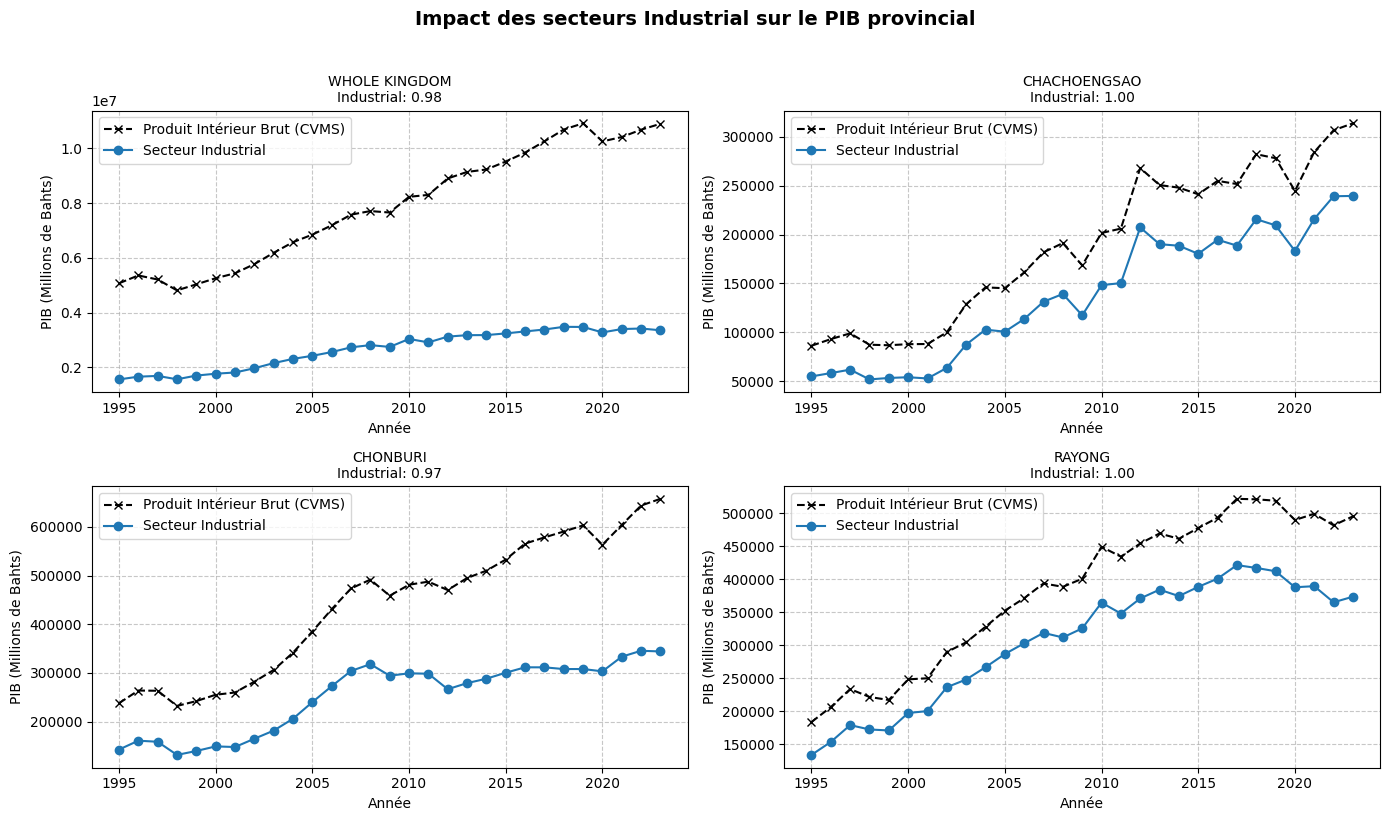

In [4]:
def plot_gdp_vs_sector(sectors=['Industrial']):
    """
    Visualise l'impact de l'industrie sur le PIB par province
    """
    gdp_data = create_GDP_dataframe(sectors=['Total GDP'] + sectors)
    years = gdp_data.index
    
    n_provinces = len(provinces)
    plt.figure(figsize=(14, 2 * n_provinces))
    
    # Main title for the whole figure
    plt.suptitle(f"Impact des secteurs {', '.join(sectors)} sur le PIB provincial", 
                 y=1.02, fontsize=14, fontweight='bold')
    
    for idx, province in enumerate(provinces):
        plt.subplot(n_provinces // 2, 2, idx + 1)
        gdp = gdp_data[f"{province} - Total GDP"]
        
        # Plot GDP first for better visibility
        plt.plot(years, gdp, label='Produit Intérieur Brut (CVMS)', 
                linestyle='--', marker='x', color='black')
    
        # Plot each sector and calculate correlations
        correlations = []
        for sector in sectors:
            sector_col = f"{province} - {sector}"
            sector_data = gdp_data[sector_col]
            corr_coef, _ = pearsonr(sector_data, gdp)
            correlations.append(f"{sector}: {corr_coef:.2f}")
            
            plt.plot(years, sector_data, label=f'Secteur {sector}', marker='o')
        
        # Subplot title with province name and correlation coefficients
        corr_text = '\n'.join(correlations)
        plt.title(f"{province}\n{corr_text}", fontsize=10)
        
        plt.ylabel('PIB (Millions de Bahts)')
        plt.xlabel('Année')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
    plt.tight_layout()
    plt.show()
    
# Exemple d'utilisation
sectors = ['Industrial']
plot_gdp_vs_sector(sectors=sectors)

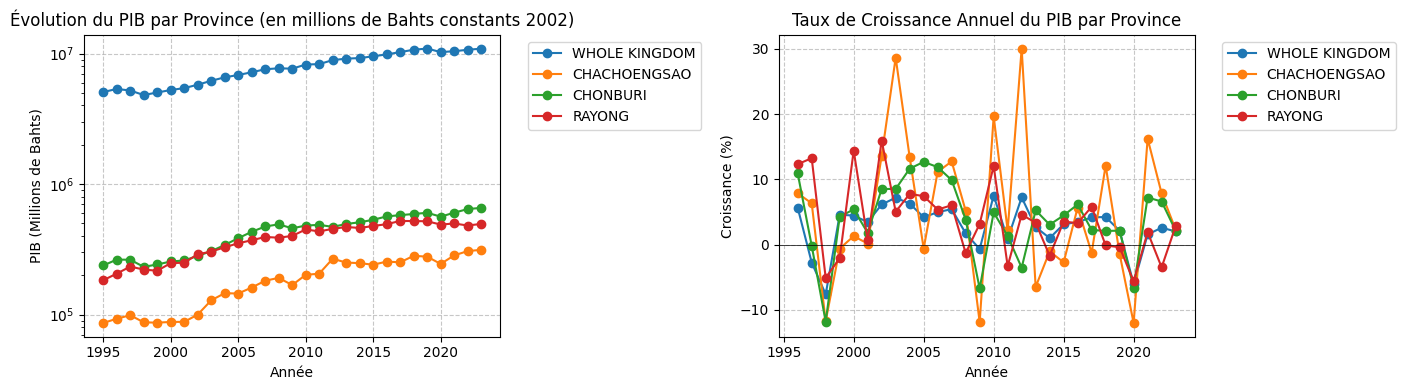

In [5]:
def plot_gdp(sector='Total GDP'):
    """
    Charge et visualise l'évolution du PIB pour toutes les provinces
    """
    gdp_data = create_GDP_dataframe()
    
    # Visualisation
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    for province in provinces:
        plt.plot(gdp_data.index, gdp_data[f"{province} - {sector}"], label=province, marker='o')

    plt.title('Évolution du PIB par Province (en millions de Bahts constants 2002)')
    plt.ylabel('PIB (Millions de Bahts)')
    plt.xlabel('Année')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Calcul des taux de croissance
    growth_rates = gdp_data.pct_change() * 100
    
    plt.subplot(1, 2, 2)
    for province in provinces:
        plt.plot(growth_rates.index, growth_rates[f"{province} - {sector}"], label=province, marker='o')

    plt.title('Taux de Croissance Annuel du PIB par Province')
    plt.ylabel('Croissance (%)')
    plt.xlabel('Année')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
plot_gdp()

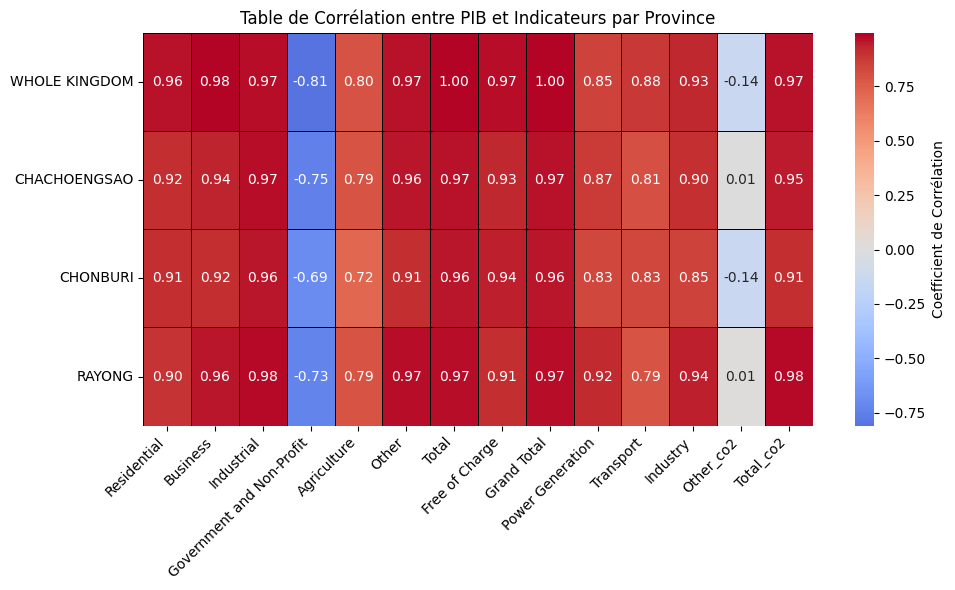

In [6]:
def province_correlation_table():
    """
    Crée une table où chaque ligne est une province et chaque colonne est un indicateur,
    chaque cellule contient le coefficient de corrélation entre le PIB de la province et l'indicateur.
    """
    # Chargement des données
    gdp_data = create_GDP_dataframe()
    elec_cons = load_electricity_data()
    co2_emissions = load_CO2_data()

    # Fusionner toutes les données sur l'index Year avec des suffixes pour éviter les conflits de colonnes
    merged = gdp_data.join(elec_cons, how='inner', lsuffix='_gdp', rsuffix='_elec')
    merged = merged.join(co2_emissions, how='inner', rsuffix='_co2')

    # Colonnes à corréler (hors PIB provinces)
    indicator_cols = [col for col in merged.columns if col not in gdp_data.columns]

    # Calcul du coefficient de corrélation pour chaque province vs chaque indicateur
    corr_table = pd.DataFrame(index=provinces, columns=indicator_cols, dtype=float)
    for prov in provinces:
        for ind in indicator_cols:
            corr_table.loc[prov, ind] = merged[f"{prov} - Total GDP"].corr(merged[ind])
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_table, annot=True, cmap='coolwarm', center=0, fmt=".2f",
                cbar_kws={"label": "Coefficient de Corrélation"},
                linewidths=.5, linecolor='black')
    plt.title('Table de Corrélation entre PIB et Indicateurs par Province')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return corr_table

# Exemple d'utilisation
province_corr = province_correlation_table()


EEC GDP as % of National GDP - Mean: 25.7%, Std Dev: 2.18%
Range: 21.3% to 28.6%


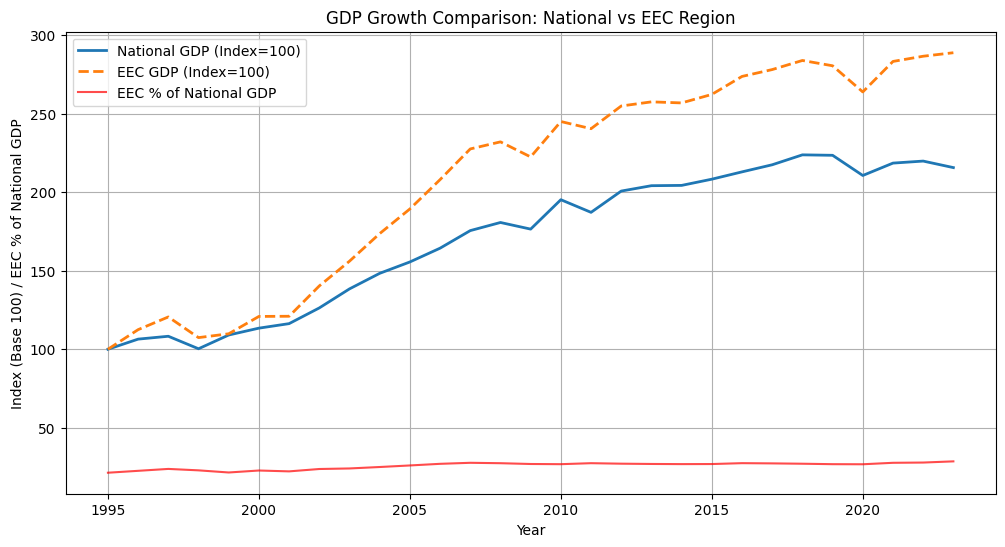

In [10]:
def get_gdp_proportion(sector='Total GDP', plot=True):
    """
    Compare EEC GDP growth to national GDP growth
    """
    gdp_data = create_GDP_dataframe(sectors=[sector])
    
    # Calculate EEC total GDP for the chosen sector
    eec_gdp = pd.DataFrame()
    for province in eec:
        province_data = gdp_data[f'{province} - {sector}']
        eec_gdp[province] = province_data

    eec_gdp['Total'] = eec_gdp.sum(axis=1)
    # National GDP
    national_gdp = gdp_data[f'WHOLE KINGDOM - {sector}']
    
    # Calculate stability of proportion
    proportion = eec_gdp['Total']/national_gdp

    if plot:
        # Print statistics
        print(f"EEC GDP as % of National GDP - Mean: {proportion.mean()*100:.1f}%, Std Dev: {proportion.std()*100:.2f}%")
        print(f"Range: {proportion.min()*100:.1f}% to {proportion.max()*100:.1f}%")
        
        # Plot comparison
        plt.figure(figsize=(12,6))
        
        # Plot national GDP
        plt.plot(national_gdp.index, national_gdp/national_gdp.iloc[0]*100, 
                label='National GDP (Index=100)', linewidth=2)
        
        # Plot EEC GDP
        plt.plot(eec_gdp.index, eec_gdp['Total']/eec_gdp['Total'].iloc[0]*100,
                label='EEC GDP (Index=100)', linestyle='--', linewidth=2)
        
        # Plot proportion
        plt.plot(eec_gdp.index, proportion * 100,
                label='EEC % of National GDP', color='red', alpha=0.7)
        
        plt.title('GDP Growth Comparison: National vs EEC Region')
        plt.ylabel('Index (Base 100) / EEC % of National GDP')
        plt.xlabel('Year')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return proportion

# Example usage
proportion = get_gdp_proportion(sector='Industrial')

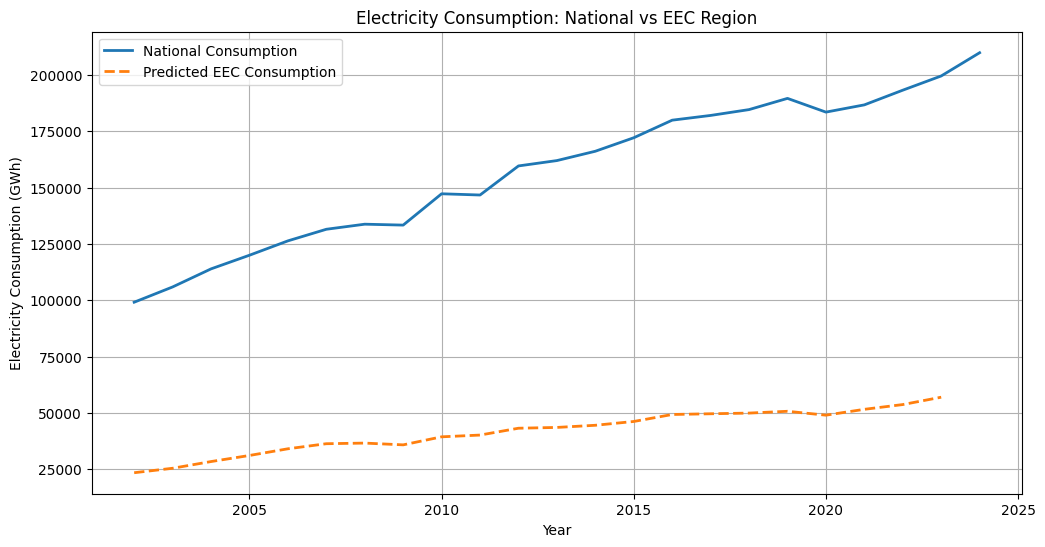

In [ ]:
def plot_electricity_proportion(sector='Total GDP', eec_consumption=None):
    """
    Compare EEC electricity consumption to what proportionality would predict
    """
    elec_cons = load_electricity_data()
    national_consumption = elec_cons['Total']

    # Get GDP proportion
    proportion = get_gdp_proportion(sector=sector, plot=False)

    # Calculate predicted EEC consumption based on national consumption and GDP proportion
    predicted_eec_consumption = national_consumption * proportion
    
    # If actual EEC consumption data is provided, calculate the correlation
    if eec_consumption is not None:
        correlation = predicted_eec_consumption.corr(eec_consumption)
        print(f"Correlation between predicted and actual EEC consumption: {correlation:.2f}")

    # Plotting
    plt.figure(figsize=(12,6))
    plt.plot(national_consumption.index, national_consumption, label='National Consumption', linewidth=2)
    plt.plot(predicted_eec_consumption.index, predicted_eec_consumption, label='Predicted EEC Consumption', linestyle='--', linewidth=2)
    if eec_consumption is not None:
        plt.plot(eec_consumption.index, eec_consumption, label='Actual EEC Consumption', linestyle=':', linewidth=2)
    plt.title('Electricity Consumption: National vs EEC Region')
    plt.ylabel('Electricity Consumption (GWh)')
    plt.xlabel('Year')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_electricity_proportion(sector='Industrial')